# Installs and imports

In [1]:
!pip install anomalib matplotlib numpy pandas sklearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 32.0 MB/s eta 0:00:00
  Created wheel for freia: filename=FrEIA-0.2-py3-none-any.whl size=42763 sha256=c3aa72b51476a750936cdf846484ba521b3f28d4524147d7e92af0b5c3861fdb
  Stored in di

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from anomalib.data import MVTecAD
from anomalib.models import Patchcore, Stfpm
from anomalib.engine import Engine
from anomalib.metrics import F1Score, AUROC, Evaluator, F1Max
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Necessary inits

In [4]:
# Datamodule inits
datamodule = MVTecAD(
    root="/content/drive/MyDrive/datasets/MVTecAD",
    category="wood",
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=2,
)

In [17]:
# Validation metrics to log
def make_evaluator():
    val_metrics = [
        AUROC(fields=["pred_score", "gt_label"]),
        F1Max(fields=["pred_score", "gt_label"])
    ]

    return Evaluator(val_metrics=val_metrics)

In [22]:
# Visualization helper functions
def plot_val_metrics(log_dir: str, model_name: str):
    import os
    metrics_path = os.path.join(log_dir, "metrics", "0", "metrics.csv")

    df = pd.read_csv(metrics_path)

    train_df = df[df["train_loss_epoch"].notna()][["epoch", "train_loss_epoch"]].reset_index(drop=True)
    val_cols  = [c for c in df.columns if c not in ("epoch", "step", "train_loss_epoch", "train_loss_step")]
    val_df    = df[df[val_cols[0]].notna()][["epoch"] + val_cols].reset_index(drop=True) if val_cols else None

    n_plots = (1 if not train_df.empty else 0) + (len(val_cols) if val_df is not None else 0)

    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 4))

    ax_idx = 0

    # Train loss
    if not train_df.empty:
        axes[ax_idx].plot(train_df["epoch"], train_df["train_loss_epoch"],
                          marker="o", color="steelblue")
        axes[ax_idx].set_title("Train Loss")
        axes[ax_idx].set_xlabel("Epoch")
        axes[ax_idx].grid(True, alpha=0.3)
        # Linear min/max scaling for loss too
        ymin, ymax = train_df["train_loss_epoch"].min(), train_df["train_loss_epoch"].max()
        margin = (ymax - ymin) * 0.1 or 0.1
        axes[ax_idx].set_ylim(ymin - margin, ymax + margin)
        ax_idx += 1

    # Val metrics
    colours = ["darkorange", "seagreen", "purple", "crimson"]
    if val_df is not None:
        for col, colour in zip(val_cols, colours):
            data = val_df[["epoch", col]].dropna()
            axes[ax_idx].plot(data["epoch"], data[col], marker="o", color=colour)
            axes[ax_idx].set_title(col)
            axes[ax_idx].set_xlabel("Epoch")
            axes[ax_idx].grid(True, alpha=0.3)
            # Zoom into actual value range with a small margin
            ymin, ymax = data[col].min(), data[col].max()
            margin = (ymax - ymin) * 0.1 or 0.01  # fallback if all values identical
            axes[ax_idx].set_ylim(ymin - margin, ymax + margin)
            ax_idx += 1

    fig.suptitle(f"{model_name} – Training Metrics", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [18]:
# And another one visualization helper
def plot_confusion_matrix(predictions, model_name: str):
    gt_all, pred_all = [], []
    for batch in predictions:
        gt = getattr(batch, "gt_label", None)
        if gt is None:
            gt = getattr(batch, "gt_labels", None)

        pred = getattr(batch, "pred_label", None)
        if pred is None:
            pred = getattr(batch, "pred_labels", None)

        if gt is None or pred is None:
            continue
        gt_all.extend(gt.cpu().numpy().flatten().tolist())
        pred_all.extend(pred.cpu().numpy().flatten().tolist())

    if not gt_all:
        print(f"[{model_name}] No label data – skipping confusion matrix.")
        return

    cm   = confusion_matrix(gt_all, pred_all)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} – Confusion Matrix", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor   │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor  │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator      │      0 │ train │     0 │
│ 3 │ model          │ PatchcoreModel │ 24.9 M │ train │     0 │
└───┴────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 24.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.9 M                                                                                               
Total estimated model params size (MB): 99                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 174                                                                                          
Total FLOPs: 0

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 174 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
Selecting Coreset Indices.: 100%|██████████| 25292/25292 [02:00<00:00, 210.24it/s]
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: `weights_only` was not set, defaulting to `False`.
INFO:lightning.pytorch.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor,

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9859648942947388     │
│       image_F1Score       │    0.9579831957817078     │
│        pixel_AUROC        │    0.9309106469154358     │
│       pixel_F1Score       │    0.46949535608291626    │
└───────────────────────────┴───────────────────────────┘

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


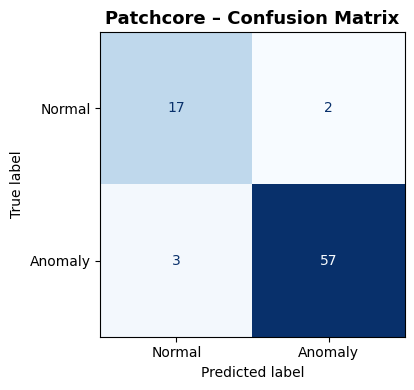

In [20]:
# Train Patchcore, only 1 epoch (there is no choice)
model_patchcore = Patchcore()

engine_patchcore = Engine(max_epochs=1, enable_progress_bar=False)
engine_patchcore.fit(model=model_patchcore, datamodule=datamodule)
engine_patchcore.trainer.save_checkpoint("/content/drive/MyDrive/models/patchcore.ckpt")

engine_patchcore.test(model=model_patchcore, datamodule=datamodule)
preds_patchcore = engine_patchcore.predict(model=model_patchcore, datamodule=datamodule)

plot_confusion_matrix(preds_patchcore, "Patchcore")

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:213: Attribute 'evaluator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['evaluator'])`.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/lib/python3.12/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /content/drive/MyDrive/logs/stfpm/metrics/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_D

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor  │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator     │      0 │ train │     0 │
│ 3 │ model          │ STFPMModel    │  5.6 M │ train │     0 │
│ 4 │ loss           │ STFPMLoss     │      0 │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 2.8 M                                                                                        
Total params: 5.6 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 69                                                                                           
Total FLOPs: 0

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/saving.py:365: Skipping 'evaluator' parameter because it is not possible to safely dump to YAML.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 69 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


INFO: `weights_only` was not set, defaulting to `False`.
INFO:lightning.pytorch.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[STFPM] Logged columns: ['AUROC', 'F1Max', 'epoch', 'step', 'train_loss_epoch', 'train_loss_step']


ValueError: Axis limits cannot be NaN or Inf

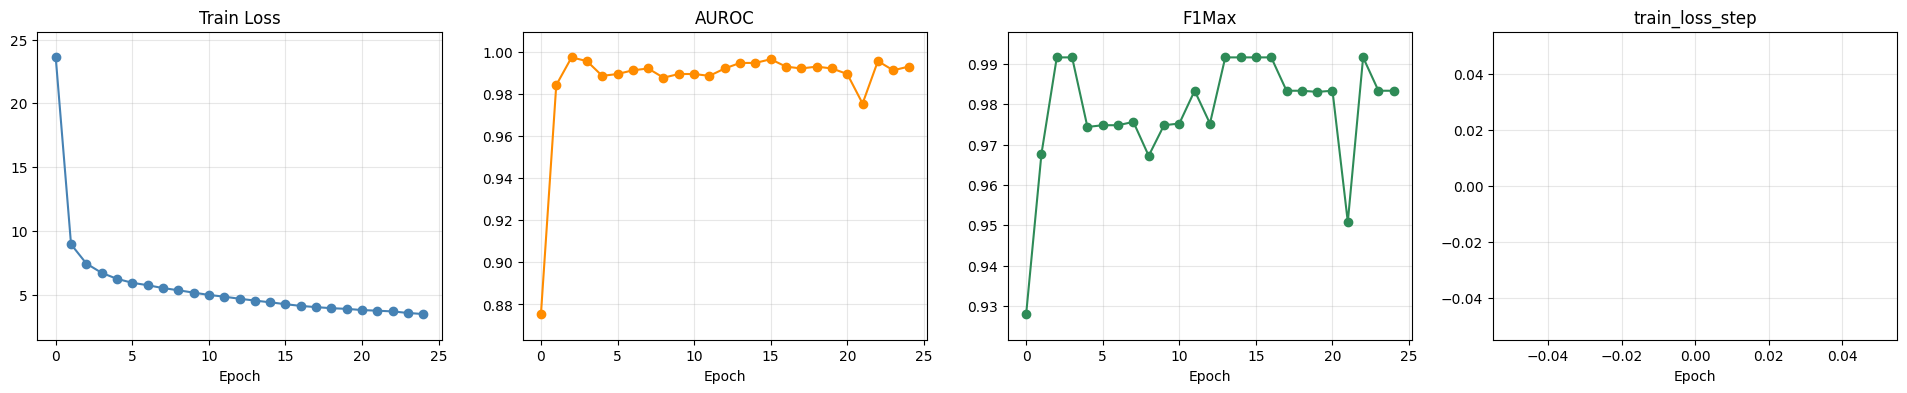

In [21]:
# First training STFPM (to evaluate optimal epochs)
model_stfpm = Stfpm(evaluator=make_evaluator())

engine_stfpm = Engine(
    max_epochs=25,
    logger=CSVLogger("/content/drive/MyDrive/logs/stfpm", name='metrics', version='0'),
)

engine_stfpm.fit(model=model_stfpm, datamodule=datamodule)
engine_stfpm.test(model=model_stfpm, datamodule=datamodule)

plot_val_metrics("/content/drive/MyDrive/logs/stfpm", "STFPM")

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor  │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator     │      0 │ train │     0 │
│ 3 │ model          │ STFPMModel    │  5.6 M │ train │     0 │
│ 4 │ loss           │ STFPMLoss     │      0 │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 2.8 M                                                                                        
Total params: 5.6 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 89                                                                                          
Modules in eval mode: 69                                                                                           
Total FLOPs: 0

Output()

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


INFO: `weights_only` was not set, defaulting to `False`.
INFO:lightning.pytorch.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.99210524559021      │
│       image_F1Score       │    0.9747899174690247     │
│        pixel_AUROC        │    0.9430363774299622     │
│       pixel_F1Score       │    0.5578283071517944     │
└───────────────────────────┴───────────────────────────┘

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

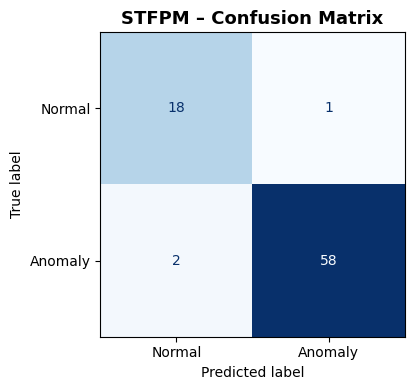

In [24]:
# Optimal SFTPM training (15 epochs)
model_stfpm = Stfpm()

engine_stfpm = Engine(max_epochs=15)

engine_stfpm.fit(model=model_stfpm, datamodule=datamodule)
engine_stfpm.trainer.save_checkpoint("/content/drive/MyDrive/models/stfpm.ckpt")

engine_stfpm.test(model=model_stfpm, datamodule=datamodule)
preds_stfpm = engine_stfpm.predict(model=model_stfpm, datamodule=datamodule)
plot_confusion_matrix(preds_stfpm, "STFPM")

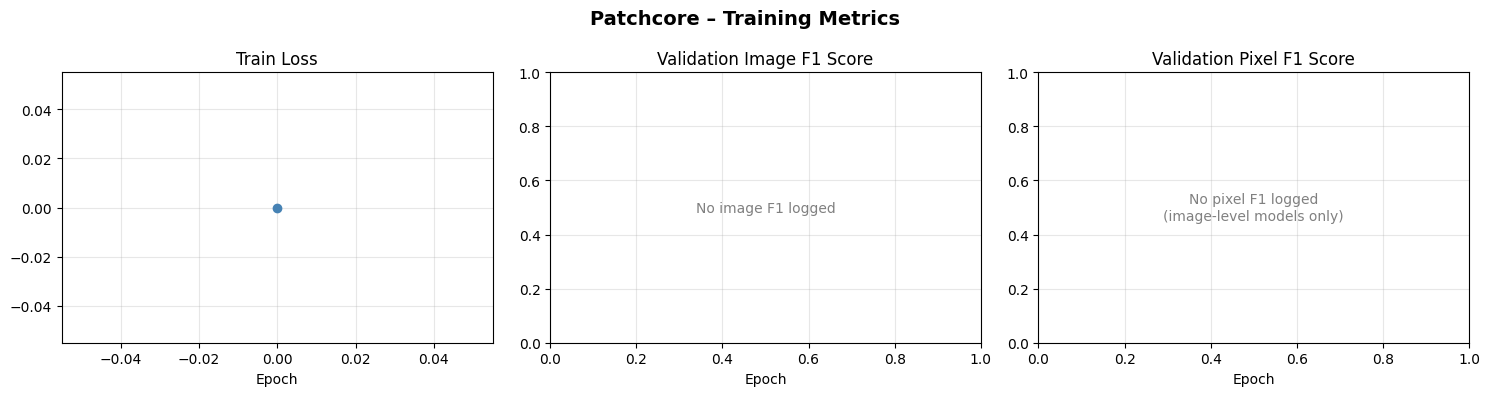

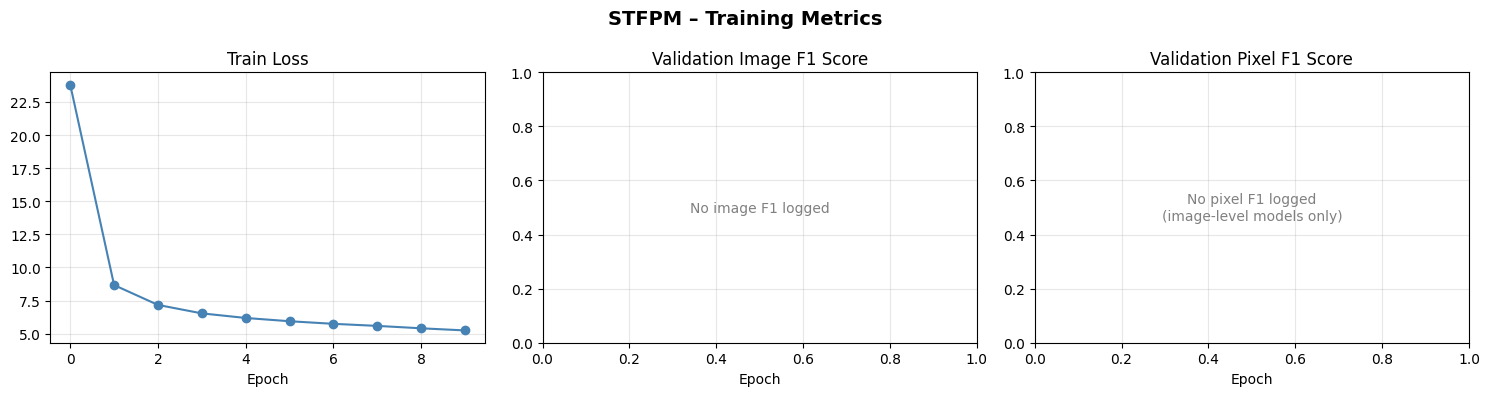

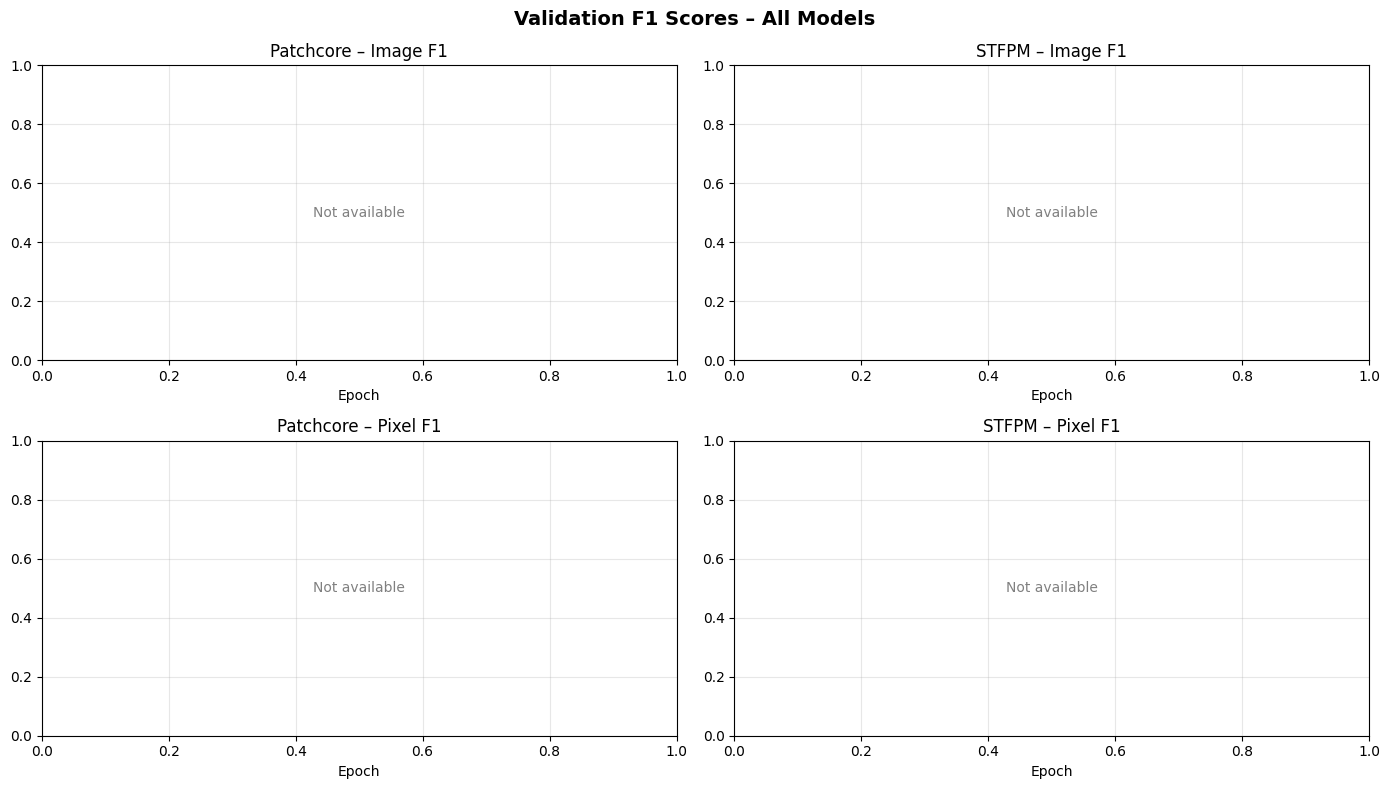

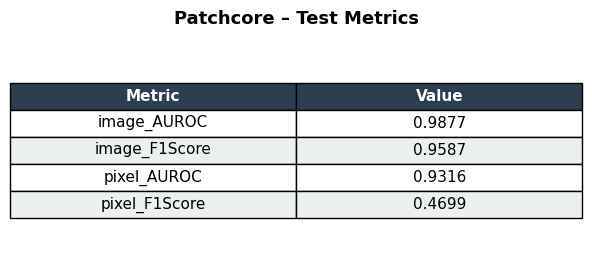

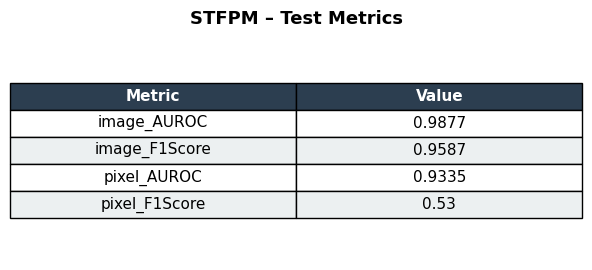

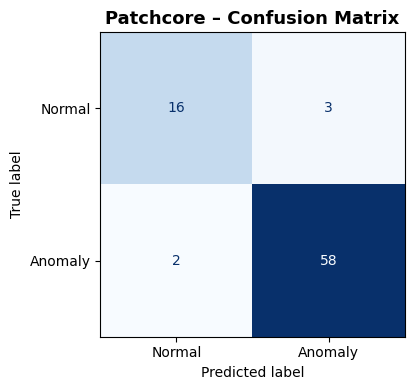

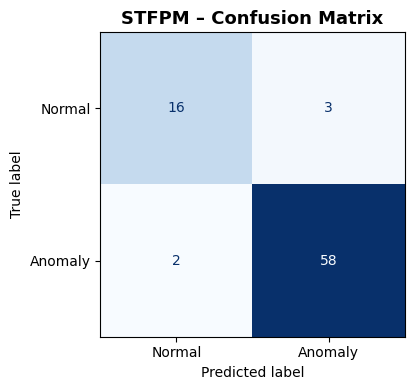

In [ ]:
# These metrics are no longer used and have no meaning, but I don't want to remove them.